In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
import spacy.cli
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
spacy.cli.download("es")
nltk.download("punkt")

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
nlp = spacy.load('es', vectors=False, entity=False)

In [43]:
dataset= ""
p = 0
for i in range(28):
    if i+1 < 10:
        path = "Periodico_castella/text_spa/2004-05-0"+str(i+1)+"/"
    else:
        path = "Periodico_castella/text_spa/2004-05-"+str(i+1)+"/"
    for filename in os.listdir(path):
        if "19" in filename:
            continue
        text_file = open(path+filename, "r", encoding='ISO-8859-1')
        text = text_file.read()
        if len(text) > 50:
            p = p +1
            dataset += text
        text_file.close()

sentences = nltk.sent_tokenize(dataset.replace("\n", " --- ").replace("---",".").replace(" .",""))
with  open("periodico", "w", encoding='ISO-8859-1') as f:
    f.write(dataset.replace("\n", " --- ").replace("---",".").replace(" .",""))
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

In [44]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

In [45]:
%%time
doc= []
dicc = {}
lista = []
word_id = 0
words = []
threshold_w = 50
threshold_c = 50
for sent in sentences:
    if len(sent) > 30:
        doc = nlp(sent)
        for word in doc:
            if word in spacy_stopwords:
                continue
            words.append(word)
            w = word.lemma_
            if not word.is_alpha or str.isdigit(w):
                continue
            if not w in dicc:
                features = {}
                features["count"] = 1
            else:
                features = dicc[w]
                features["count"] +=1
            
        
            pos = "POS__" + word.pos_
            if not pos in features:
                features[pos] = 0
            features[pos] += 1

            dep = "DEP__" + word.dep_
            if not dep in features:
                features[dep] = 0
            features[dep] += 1

            tags = parse_tags(word)
            for tag in tags:
                if not tag in features:
                    features[tag] = 0
                features[tag] += 1
                
            for wod in doc:
                if not word.i == wod.i and not word == wod:
                    wod_lemma = wod.lemma_
                    if wod.is_alpha:
                        if str.isdigit(wod_lemma):
                            wod_lemma = "NUM__"
                        if not wod_lemma in features:
                            features[wod_lemma] = 0
                        features[wod_lemma] += 1


            word_id += 1

            dicc[w] = features

CPU times: user 2min 29s, sys: 2.33 s, total: 2min 31s
Wall time: 2min 41s


In [46]:
threshold_w = 30
tail_off = dict(filter(lambda elem: elem[1]["count"] >= threshold_w,dicc.items()))
for key in tail_off:
    print(key,tail_off[key]["count"])

La 548
de 7497
EEUU 90
lo 6007
seguridad 50
El 684
estadounidense 51
el 3568
más 465
importante 43
desde 104
segundar 57
guerra 52
poder 296
a 2062
si 117
no 788
se 1262
tomar 47
medir 42
alto 46
responsable 54
este 445
ante 65
sobrar 180
los 1138
haber 1005
uno 2274
sin 127
soldar 38
y 2437
ser 1419
llamar 36
parir 706
participar 31
en 2852
del 1681
o 182
ir 98
Irak 80
marcar 31
Los 175
que 3579
seguir 100
situación 55
realizar 42
vez 102
país 89
al 655
con 964
BARCELONA 103
Catalunya 97
ofrecer 46
su 901
nuevo 162
obrar 69
europeo 44
e 86
medio 71
mujer 71
lugar 57
partir 214
José 51
cultura 34
recordar 47
músico 33
llevar 79
año 300
propio 54
temer 38
todo 280
trabajar 86
perder 34
cuando 133
él 107
estar 378
Por 66
ese 191
hacer 366
seis 41
quedar 38
problema 49
mientras 51
comer 451
otro 241
por 980
librar 40
mismo 121
director 93
querer 97
disponer 33
programar 51
antes 81
También 41
primero 92
Barcelona 129
semana 58
público 121
salir 55
dejar 72
británico 38
publicar 33
ayer 25

In [47]:
%%time
for d in tail_off:
#    del dicc[d]["count"]
    banned = []
    for word in tail_off[d]:
        if word == "count" or "__" in word or "=" in word or word == '_':
            continue
        if dicc[word]['count'] <= 75:
            banned.append(word)
    for word in banned:
        del dicc[d][word]
#for d in tail_off:
#    del tail_off[d]["count"]

CPU times: user 1.11 s, sys: 28.3 ms, total: 1.13 s
Wall time: 1.23 s


In [48]:
features = []
key_words = {}
wid = 0
for d in tail_off:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [49]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [50]:
matrix_normed = matrix / matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [51]:
%%time
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(matrix_normed)

CPU times: user 6.55 s, sys: 65.1 ms, total: 6.61 s
Wall time: 6.87 s


In [52]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

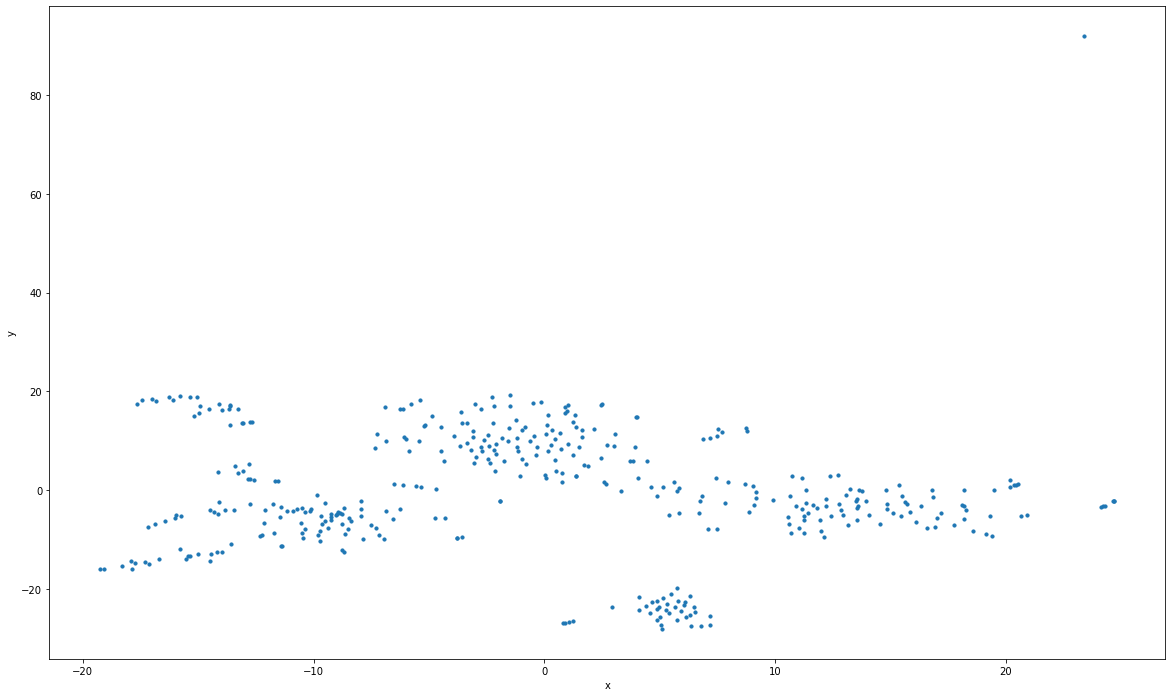

In [53]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [54]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [55]:
%%time
c50 =  clustering(100)

CPU times: user 6.43 s, sys: 127 ms, total: 6.56 s
Wall time: 6.88 s


In [56]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], c50[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

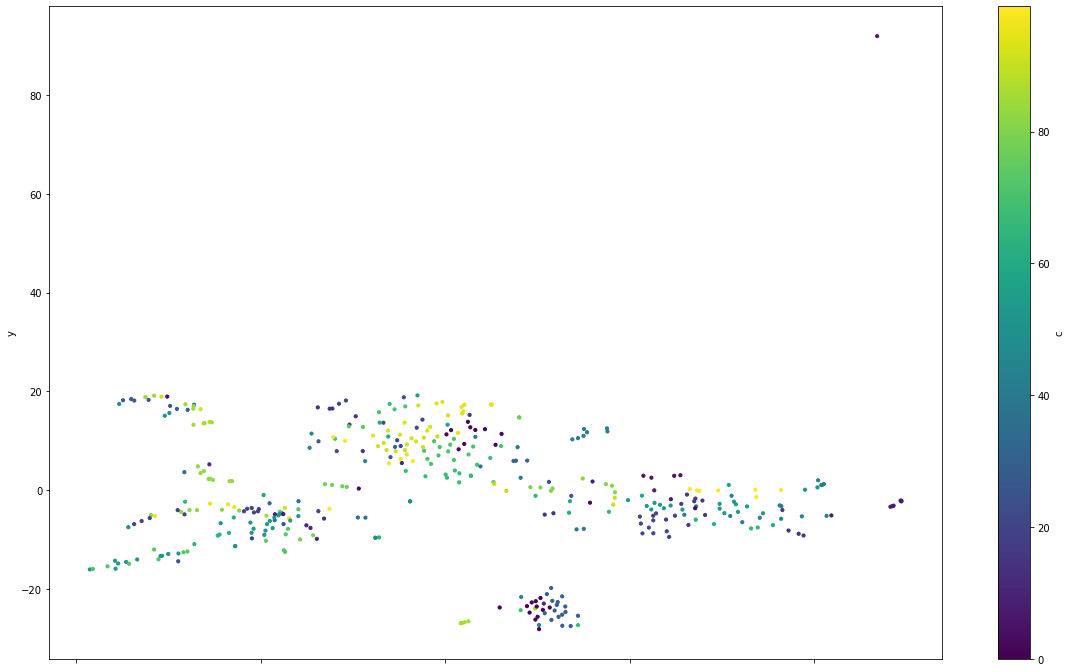

In [57]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [58]:
printer = [word for word in key_words if c50[key_words[word]] == c50[key_words["EEUU"]]]
print(printer)

['EEUU', 'Estado', 'Gobierno', 'PP', 'Europa']


In [59]:
printer_dic={}
for word in key_words:
    if c50[key_words[word]] not in printer_dic:
        printer_dic[c50[key_words[word]]] = [word]
    else:
        printer_dic[c50[key_words[word]]].append(word)
for key in sorted(printer_dic.keys()) :
    print(key , " :: " , printer_dic[key])

0  ::  ['alto', 'nuevo', 'europeo', 'principal', 'bueno', 'grande', 'mejor', 'especial', 'pequeño', 'disponible', 'próximo', 'anterior']
1  ::  ['cultura', 'información', 'televisión', 'servicio', 'equipar', 'derecho', 'grupo', 'niño', 'torturar', 'vivienda']
2  ::  ['seis']
3  ::  ['trabajar', 'esperar']
4  ::  ['Irak']
5  ::  ['conseguir', 'presenciar', 'viajar', 'funcionar']
6  ::  ['Con']
7  ::  ['tener', 'tratar', 'existir']
8  ::  ['asegurar', 'mantener', 'ver', 'creer', 'informar', 'afirmar']
9  ::  ['me', 'nuestro', 'mi']
10  ::  ['DE', 'EN', 'DEL']
11  ::  ['real']
12  ::  ['decisión']
13  ::  ['director', 'hombre', 'unir', 'millón', 'secretario', 'presidente']
14  ::  ['poder', 'haber', 'ser', 'estar', 'Es', 'deber']
15  ::  ['mañana']
16  ::  ['centrar']
17  ::  ['producir', 'intentar', 'llegar', 'cerrar', 'suponer', 'morir', 'demostrar', 'obligar', 'anunciar', 'conocer']
18  ::  ['sobrar', 'sino']
19  ::  ['más', 'También', 'ayer', 'ya', 'tan', 'ahora', 'Además', 'muy', 'au